[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sandy-lee29/musicapp-review-analysis/blob/main/App_Review_Tagging_with_AI.ipynb)


#📱 App Review Tagging  
## 🎧 Industry: Music
### Companies Analyzed:
*   Spotify
*   Apple Music
*   Amazon Music
*   Youtube Music

In [ ]:
%pip install python-dotenv

In [ ]:
from dotenv import load_dotenv, find_dotenv
import os
import json
import uuid
import pandas as pd
import re
import openai
from typing import List, Dict, Any
from openai import OpenAI
import time


##  📌 Bring in App Reviews + Create review_id for IOS reviews

In [ ]:
df = pd.read_csv('music_sample.csv')

In [ ]:
# Regular Expression to add review_id as a column
uuid_pattern = re.compile(r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$', re.IGNORECASE)
df['review_id'] = df['review_id'].apply(
    lambda x: str(uuid.uuid4()) if not (isinstance(x, str) and uuid_pattern.match(x)) else x
)

df.head()

,review_id,review,rating,time,company,data_source
0,94038946-6e27-411a-bcdb-60e0824315fb,i mean apple music is a really good app espec...,3,1/10/2023 21:53,Apple Music,IOS
1,52d4e6c8-82d3-477a-b37d-15d8897a4541,i just wanted to explore the app but immediate...,2,9/30/2021 12:28,Amazon Music,IOS
2,69363cf5-3e0e-498b-a28c-46f606c32fa0,it just loops songs does not generate new play...,1,2/18/2025 23:46,Amazon Music,Android
3,1bd877b4-a132-49e3-ba4b-3f3db5216311,at this point i feel like i paid for premium ...,1,2/25/2025 15:49,Spotify,Android
4,6d249900-e97d-4ec8-af1d-a1ebcc8195c2,i love dis app as a true music lover able to ...,5,2/22/2025 1:59,Apple Music,Android


In [ ]:
df.count()

,0
review_id,1000
review,1000
rating,1000
time,1000
company,1000
data_source,1000


# 🎯 Customer Review Analysis Pipeline (High-Level Overview)

## 📌 1. Data Loading & Environment Setup
- Load **customer reviews dataset** (`music_sample.csv`).
- Retrieve **OpenAI API key** from `.env` file.
- Initialize **OpenAI client** for API calls.

## 📌 2. OpenAI API Call for Review Analysis
**Purpose:** Extract **sentiment, problems, aspects, and topics** from customer reviews.  
**Process:**
- Define **sentiment classification rules**.
- Send **review text** to `GPT-4o-mini`.
- Receive structured **JSON response**:
  - **Sentiment** (positive, neutral, negative)
  - **Problems** (if any)
  - **Aspects** (generalized issue category)
  - **Topics** (standardized topic classification)

## 📌 3. Topic Standardization
Convert extracted topics into consistent, predefined categories to ensure structured analysis.
<br>
- Step 1: Predefined Topic Matching
  - If the extracted topic exactly matches a predefined category, it is used as-is. <br>
- Step 2: Smart Topic Mapping  
  - If there is no exact match, the system searches for the closest predefined category.
  - Uses text normalization (removing unnecessary words, fixing spacing, handling variations).
  - Measures similarity score between extracted topics and predefined categories using NLP techniques. <br>
- Step 3: Fallback Handling
  - If no close match is found, the topic is categorized as "other".

## 📌 4. Data Processing & Transformation
- **Neutral/Negative reviews** must have at least **one problem, aspect, and topic**.
- **Positive reviews** retain sentiment but **exclude problems**.
- Limit extracted issues to **one per 200 characters** to avoid redundancy.
- **Apply topic standardization** to align topics across reviews.

## 📌 5. Sampling & Output Generation
- Randomly **sample 500 reviews**.
- Execute the **review analysis pipeline**.
- Save processed dataset as **`processed_reviews.csv`**.

## 🎤 Key Takeaways
✔ **Automated** sentiment & issue extraction using **OpenAI API**.  
✔ **Standardized** topic categorization for better insights.  
✔ **Structured & scalable** approach to analyzing customer feedback.  


##  📌 Initialize OpenAI API Key




In [ ]:
with open(".env", "w") as f:
    f.write("Add your Key Here")

In [ ]:
# Load environment variables from .env file
dotenv_path = "/content/.env"
load_dotenv(dotenv_path)


# Get the OpenAI API key
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI API client with the API key
client = OpenAI(api_key=openai_api_key)

In [ ]:
def prompting(task_name: str, system_prompt: str, user_input: str, json_formatter: Dict[str, Any]) -> Dict[str, Any]:
    """
    Standardized function for calling OpenAI API.

    Parameters:
    -----------
    - task_name: str → The name of the request task (e.g., "get_pcs", "extract_problems").
    - system_prompt: str → System prompt defining AI's role and instructions.
    - user_input: str → User input containing the review text for analysis.
    - json_formatter: Dict[str, Any] → JSON schema specifying the expected API response format.

    Returns:
    --------
    - Dict[str, Any] → JSON response from OpenAI API.
    """
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_input},
        ],
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": task_name,
                "schema": json_formatter,
                "strict": True
            }
        },
        max_tokens=2000,
        temperature=0.7,
    )

    return json.loads(response.choices[0].message.content)

In [ ]:
import difflib  # For similarity matching

# Function to Standardize Topics with Industry-Specific Enhancements
def standardize_topic(topic: str) -> str:
    """Standardizes topic names based on predefined rules and automatic generalization."""

    # Normalize the topic string
    topic = topic.lower().strip()
    topic = topic.replace("app ", "").replace("application ", "")
    topic = topic.replace("/", " ").replace("-", " ").replace("_", " ")

    # Broad topics with predefined keywords
    predefined_categories = {
        "usability": [
            "ui issues", "navigation problems", "user experience", "accessibility", "ease of use",
            "complex interface", "poor design choices", "difficult to navigate", "unintuitive layout",
            "hard to use", "confusing interface", "user unfriendly", "complicated menus"
        ],
        "functionality": [
            "feature request", "missing feature", "broken feature", "app functionality",
            "inconsistent behavior", "limited customization options", "feature not working",
            "functionality issues", "feature malfunction", "unavailable features", "feature glitches"
        ],
        "performance": [
            "slow app speed", "app lagging", "performance issues", "crash", "freezes", "buffering",
            "high battery consumption", "excessive data usage", "slow loading", "app hangs",
            "unresponsive app", "performance lag", "battery drain", "memory usage issues"
        ],
        "security": [
            "security risk", "privacy concern", "data protection", "account security",
            "unauthorized charges", "data leaks", "intrusive permissions", "security vulnerability",
            "data breach", "unsecured connection", "privacy invasion", "security flaws"
        ],
        "customer_service": [
            "customer support", "support issues", "help desk response", "slow response time",
            "unhelpful support", "refund issues", "account recovery problems", "poor customer service",
            "no support", "unresponsive support", "support not helpful", "difficult to contact support"
        ],
        "pricing": [
            "pricing issues", "subscription cost", "perceived value", "monetization concerns",
            "hidden fees", "auto renewal problems", "difficult cancellation", "price increase",
            "expensive subscription", "unjustified cost", "billing issues", "overpriced"
        ],
        "content": [
            "content access", "content discovery", "content recommendations", "content quality",
            "region locked content", "missing content", "irrelevant suggestions", "limited library",
            "outdated content", "poor content selection", "content not updating", "content availability"
        ],
        "ads": [
            "too many notifications", "spammy ads", "intrusive popups", "irrelevant ads", "ad frequency",
            "unable to disable ads", "annoying advertisements", "ads interrupting", "excessive advertising",
            "forced ads", "advertising overload", "ads disrupting experience", "excessive advertisements", "advertisements", "ads"
        ],
        # Music app-specific issues
        "recommendation_system": [
            "playlist recommendations", "algorithm accuracy", "music suggestions", "personalized playlists",
            "recommendation relevance", "song suggestions", "curated playlists", "music discovery",
            "recommendation engine", "suggested tracks", "playlist curation", "music matching"
        ],
        "offline_listening": [
            "download limitations", "offline mode issues", "music downloads", "offline playback",
            "downloaded songs disappearing", "offline access", "download errors", "offline functionality",
            "download restrictions", "offline listening problems", "download quality", "offline mode limitations"
        ],
        "audio_quality": [
            "low bitrate", "sound quality issues", "streaming quality", "audio fidelity", "poor sound quality",
            "audio glitches", "sound distortion", "quality loss", "uneven volume", "audio dropouts",
            "sound clarity", "audio performance", "audio", "audio quality"
        ],
        "cross_platform_compatibility": [
            "device support", "os compatibility", "third party integrations", "platform sync issues",
            "multi device support", "compatibility problems", "integration with other apps", "cross device functionality",
            "platform limitations", "syncing issues", "device pairing", "compatibility errors"
        ]
    }

    # Exact match first
    for standard_topic, variations in predefined_categories.items():
        if topic in variations:
            return standard_topic  # Return standardized topic if exact match

    # Approximate matching for broad categorization
    for broad_topic, variations in predefined_categories.items():
        for variation in variations:
            similarity = difflib.SequenceMatcher(None, topic, variation).ratio()
            if similarity > 0.7:  # If similarity is above 70%, categorize it broadly
                return broad_topic

    return "other"  # Default to "other" if no close match


# 📌 Main Function for Sentiment & Problem Analysis
def apply_sentiment_problem_analysis(df: pd.DataFrame, api_key: str) -> pd.DataFrame:
    """Processes a DataFrame containing customer reviews and extracts structured information."""

    print("Existing columns in DataFrame:", df.columns.tolist())

    # ✅ System Prompt with Updated Rules for Sentiment Classification
    system_prompt = """
    You are analyzing customer reviews to extract structured information.
    Each review contains potential problems, aspects, and sentiments.

    **Sentiment Classification Rules:**
    - **Positive**: The review expresses strong satisfaction, enthusiasm, or clear approval.
      - Even if there is a small issue mentioned, the overall sentiment is clearly positive.
      - Strong recommendation words like "love", "amazing", "best", "highly recommend", "great experience" are key indicators.
    - **Neutral**: The review contains both positive and negative aspects, but does not strongly favor one side.
      - It may include mild suggestions for improvement while still being generally balanced.
    - **Negative**: The review expresses dissatisfaction, frustration, or a clear complaint.



    **Sentiment Classification Rules:**
    - **Positive**: The review expresses strong satisfaction, enthusiasm, or clear approval.
       - **Even if there is a minor issue, the review must be classified as positive if the overall tone is clearly enthusiastic or highly satisfied.**
       - **Positive words such as "love", "amazing", "best", "fantastic", "highly recommend", "great experience", "very useful", "super helpful" strongly indicate a positive sentiment.**
       - If a review contains **praise that outweighs a minor complaint**, classify it as positive.
     - Examples of positive reviews:
       - `"I love this app! It works perfectly and I use it every day."`
       - `"This is the best app I have ever used. Highly recommend it!"`
       - `"Very useful and convenient. A must-have!"`
       - `"Great experience, the recommendations are spot on!"`
       - `"Super helpful, but I wish it had more features."`

    - **Neutral**: The review contains both positive and negative aspects but does not strongly favor one side.
       - The review must be **clearly mixed or balanced** to be considered neutral.
       - If a review is **mostly positive with a small complaint, classify it as positive instead.**
      - Examples of neutral reviews:
       - `"The app is useful, but it crashes sometimes."`
       - `"The service is okay. Not great, but not bad either."`
       - `"It's good, but I wish it had more features."`

     - **Negative**: The review expresses dissatisfaction, frustration, or a clear complaint.


    **Analysis Process:**
    1) Identify sentiment (positive, negative, or neutral).
    2) Extract exact phrasing of problems from negative & neutral reviews.
       - If positive, return an empty list for problems.
       - Extract **max 1 problem per 200 characters** in the review text, prioritizing the most critical issues. If multiple issues exist, rank them by relevance and severity, ensuring that the most significant problems are captured first. Avoid selecting minor or redundant issues when more critical problems are present elsewhere in the text.
    3) Generalize each problem into a broader 'aspect' category.
       - **Each aspect must be at least 2-3 words long**.
    4) Assign each aspect to a corresponding broad 'topic' using standardization rules.
     - Convert topics to **lowercase**.
     - Use **broad** topics (max **2 words**).
     - Remove "app" or "application" from topics.
     - Merge similar topics into **one standard term** to prevent fragmentation.
     - If an exact match exists in the predefined topic list, use the predefined term.
     - If an exact match does not exist, find the most similar predefined topic using similarity matching (minimum 50% similarity).
     - **Industry-specific topics are dynamically updated within the predefined topic list.**
     - General topics apply to all app types (e.g., usability, functionality, performance, security, customer service, value, content, ads).
     - **App-specific topics are updated separately based on the industry category.**
       - **For music streaming apps:** Includes "recommendation system," "offline listening," "audio quality," and "cross-platform compatibility."
     - If a topic does not match any predefined category or is not sufficiently similar (similarity < 50%), it defaults to `"other"`.


    **Output Requirements:**
    - Return structured JSON with review_id, sentiment, problems, aspects, topics.
    - Neutral and Negative reviews **MUST have at least one problem, aspect, and topic.**
    - Positive reviews must be included but should have empty lists for problems, aspects, and topics.
    """

    # ✅ JSON schema for AI response
    json_formatter = {
        "type": "object",
        "properties": {
            "review_id": {"type": "string"},
            "sentiment": {"type": "string"},
            "problems": {"type": "array", "items": {"type": "string"}} if "sentiment" != "positive" else [],
            "aspects": {"type": "array", "items": {"type": "string"}} if "sentiment" != "positive" else [],
            "topics": {"type": "array", "items": {"type": "string"}} if "sentiment" != "positive" else []
        },
        "required": ["review_id", "sentiment", "problems", "aspects", "topics"],
        "additionalProperties": False
    }

    expanded_reviews = []

    for _, row in df.iterrows():
        review_id = str(row["review_id"])
        review_text = row["review"]

        # Retrieve additional fields
        review_time = row.get("time", "")
        review_rating = row.get("rating", "")
        company = row.get("company", "")
        data_source = row.get("data_source", "")

        # Construct user input for AI model
        user_input = f"""
        Analyze the following customer review:
        - Review ID: {review_id}
        - Review Text: "{review_text}"
        """

        try:
            # Call AI model
            response = prompting("analyze_review_sentiment", system_prompt, user_input, json_formatter)

            sentiment = response["sentiment"]

            # ✅ If sentiment is positive, enforce empty lists
            if sentiment == "positive":
                problems, aspects, topics = [], [], []
            else:
                problems = response["problems"]
                aspects = response["aspects"]
                topics = response["topics"]

                # 🔹 Limit Problems to 1 per 200 Characters
                max_problems = max(1, len(review_text) // 200)
                problems, aspects, topics = problems[:max_problems], aspects[:max_problems], topics[:max_problems]

                # ✅ Ensure Neutral & Negative Reviews Always Have At Least One Problem
                if not problems or not aspects or not topics:
                    problems = problems or ["N/A"]
                    aspects = aspects or ["N/A"]
                    topics = topics or ["N/A"]

            # 🔹 Aspect Index & Topic Standardization
            for idx, (problem, aspect, topic) in enumerate(zip(problems, aspects, topics), start=1):
                aspect_index = f"{review_id}_{idx}_{uuid.uuid4().hex[:8]}"
                standardized_topic = standardize_topic(topic)  # ✅ Apply topic standardization

                expanded_reviews.append({
                    "review_id": review_id,
                    "review": review_text,
                    "rating": review_rating,
                    "time": review_time,
                    "aspect_index": aspect_index,
                    "topic": standardized_topic,
                    "problem": problem,
                    "sentiment": sentiment,
                    "aspect": aspect,
                    "modified_flag": False,
                    "company": company,
                    "data_source": data_source
                })

        except Exception as e:
            print(f"Error processing review {review_id}: {e}")

    # Convert processed data into a DataFrame
    processed_df = pd.DataFrame(expanded_reviews)

    # ✅ Arrange columns in a specific order
    column_order = ["review_id", "review", "rating", "time", "aspect_index",
                    "topic", "problem", "sentiment", "aspect", "modified_flag",
                    "company", "data_source"]

    processed_df = processed_df[column_order]

    return processed_df


In [ ]:
# Extract 500 samples from the dataset
df_sample = df.sample(n=500, random_state=42)

# Execute
processed_sample_df = apply_sentiment_problem_analysis(df_sample, api_key=openai_api_key)

# Save the processed sample data to a CSV file
processed_sample_df.to_csv("processed_reviews.csv", index=False)


Existing columns in DataFrame: ['review_id', 'review', 'rating', 'time', 'company', 'data_source']


In [ ]:
print(processed_sample_df.head())

                              review_id  \
0  a1dc8fbf-6eaa-4da9-884a-117dfc4b2e00   
1  fb0526c3-1276-4a8f-b618-182578bb492c   
2  f254e427-5b4b-4a64-a271-a3fd0214f166   
3  f59a3cc8-30f2-4131-aecf-e78d3e312099   
4  47a4ef8b-9265-4897-a319-8d59a1e14c5e   

                                              review  rating             time  \
0  youtube music does not play music downloaded o...       1   2/26/2025 5:53   
1  i cant even sign up i was getting tired of spo...       1  8/21/2024 20:20   
2  starting out  they give you the premium versio...       1  11/7/2019 19:20   
3  terrible experience when purchasing and downlo...       2  2/17/2025 16:17   
4  i want to know how you fix the bugs because my...       2  2/15/2025 12:23   

                                      aspect_index          topic  \
0  a1dc8fbf-6eaa-4da9-884a-117dfc4b2e00_1_36b210af  functionality   
1  fb0526c3-1276-4a8f-b618-182578bb492c_1_e7ac11ec          other   
2  f254e427-5b4b-4a64-a271-a3fd0214f166_1_079f1

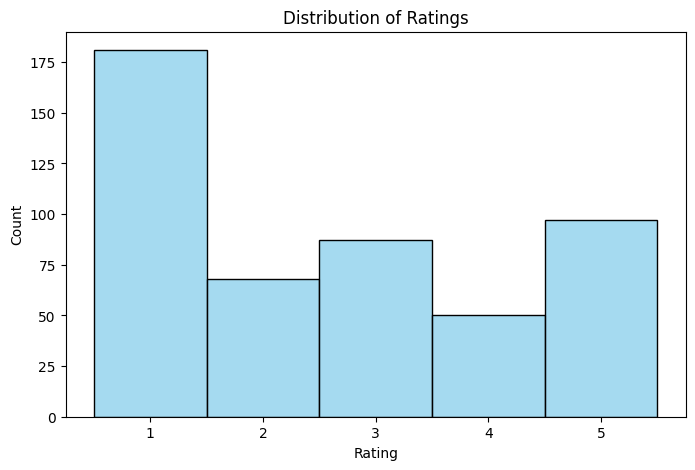

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(processed_sample_df['rating'], bins=5, kde=False, color='skyblue', discrete=True)

# Check Distribution of Ratings
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')


plt.xticks([1, 2, 3, 4, 5])
plt.show()


<ipython-input-83-14c9b5fbc8ee>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


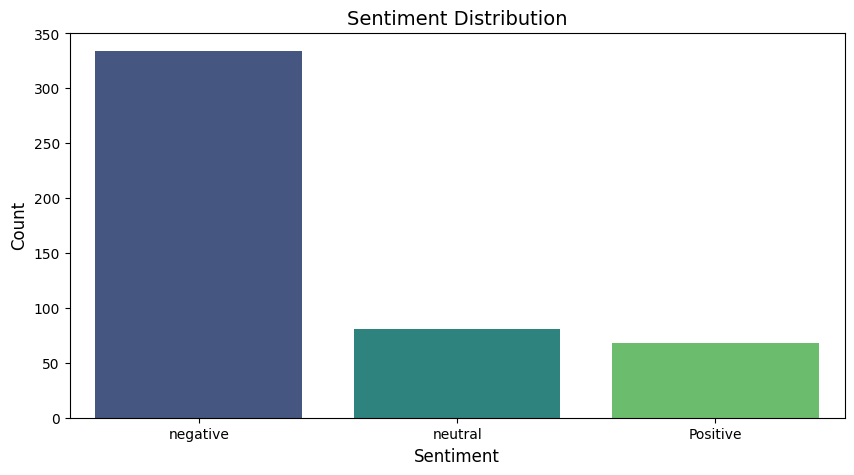

<ipython-input-83-14c9b5fbc8ee>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=topic_counts.index, x=topic_counts.values, palette="coolwarm")


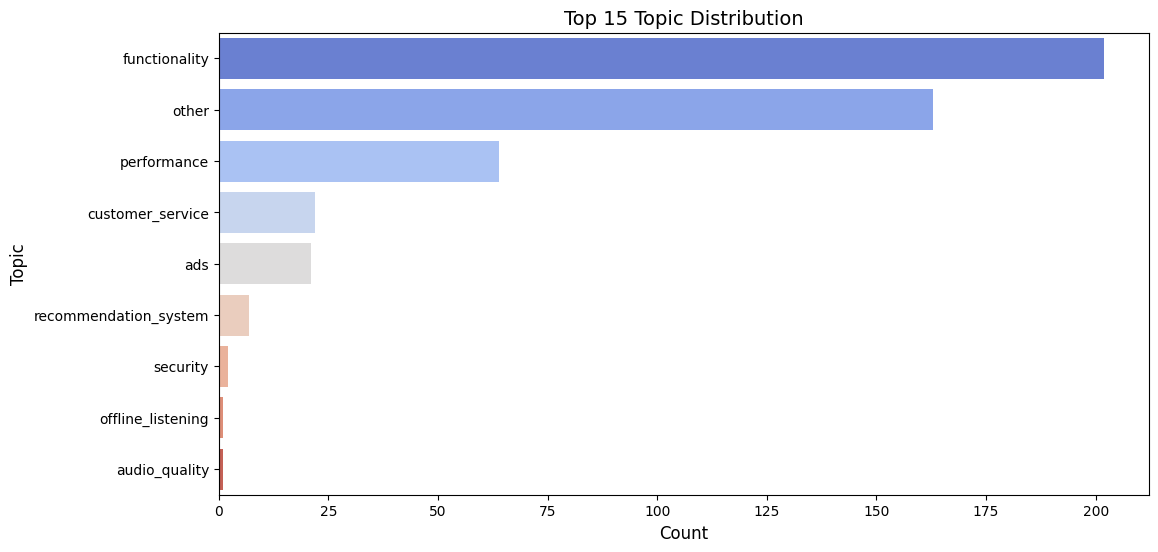

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_sentiment_topic_distribution(processed_sample_df: pd.DataFrame):
    """Visualizes sentiment and topic distribution from processed review data."""

    # ✅ Sentiment Distribution
    sentiment_counts = processed_sample_df["sentiment"].value_counts()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
    plt.title("Sentiment Distribution", fontsize=14)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=0)
    plt.show()

    # ✅ Topic Distribution (Top 15)
    topic_counts = processed_sample_df["topic"].value_counts().head(15)  # Get top 15 topics

    plt.figure(figsize=(12, 6))
    sns.barplot(y=topic_counts.index, x=topic_counts.values, palette="coolwarm")
    plt.title("Top 15 Topic Distribution", fontsize=14)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Topic", fontsize=12)
    plt.show()

# ✅ Run the visualization function on processed_sample_df
visualize_sentiment_topic_distribution(processed_sample_df)


In [ ]:
# Count occurrences of each topic
topic_counts = processed_sample_df["topic"].value_counts()

# Display the topic counts
print(topic_counts)


topic
functionality            202
other                    163
performance               64
customer_service          22
ads                       21
recommendation_system      7
security                   2
offline_listening          1
audio_quality              1
Name: count, dtype: int64


In [ ]:
# Count occurrences of each topic
topic_counts = processed_sample_df["topic"].value_counts()

# Get the top 5 topics
top_5_topics = topic_counts.head(5)

# Calculate the total count of topics
total_count = topic_counts.sum()

# Calculate the percentage of each of the top 5 topics
top_5_percentage = (top_5_topics / total_count) * 100

# Display the top 5 topics, their counts, and their percentage
print("Top 5 Topics Counts:")
print(top_5_topics)

print("\nPercentage of Top 5 Topics:")
print(top_5_percentage)

print("\nTotal Count of Topics:", total_count)


Top 5 Topics Counts:
topic
functionality       202
other               163
performance          64
customer_service     22
ads                  21
Name: count, dtype: int64

Percentage of Top 5 Topics:
topic
functionality       41.821946
other               33.747412
performance         13.250518
customer_service     4.554865
ads                  4.347826
Name: count, dtype: float64

Total Count of Topics: 483
